In [17]:
!git clone https://github.com/abhyuditjain/pytorch-models
!mv pytorch-models/models ./
!mv pytorch-models/utils ./
!mv pytorch-models/main.py ./
!rm -rf pytorch-models

Cloning into 'pytorch-models'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 175 (delta 111), reused 118 (delta 54), pack-reused 0
Receiving objects: 100% (175/175), 54.73 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [2]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from utils.transforms import Session11Transforms
from models.resnet import ResNet18
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import (
    show_misclassified_images,
    show_training_images,
    show_grad_cam,
    show_losses_and_accuracies,
    get_device,
    show_lr_history,
)
from main import train_model, get_lr

/home/carb0n/.pyenv/versions/3.10.12/envs/era-v1-pyenv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
is_cuda_available, device = get_device()
print_summary(ResNet18(), device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
ResNet (ResNet)                          --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Conv2d (conv1)                         [3, 3]                    [20, 3, 32, 32]           [20, 64, 32, 32]          1,728                     35,389,440                True
├─BatchNorm2d (bn1)                      --                        [20, 64, 32, 32]          [20, 64, 32, 32]          128                       2,560                     True
├─Sequential (layer1)                    --                        [20, 64, 32, 32]          [20, 64, 32, 32]          --                        --                        True
│    └─BasicBlock (0)                    --                        [20, 64, 32, 32]          [20, 64, 32, 32]      

In [4]:
cifar10 = Cifar10DataLoader(Session11Transforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

Files already downloaded and verified
Files already downloaded and verified


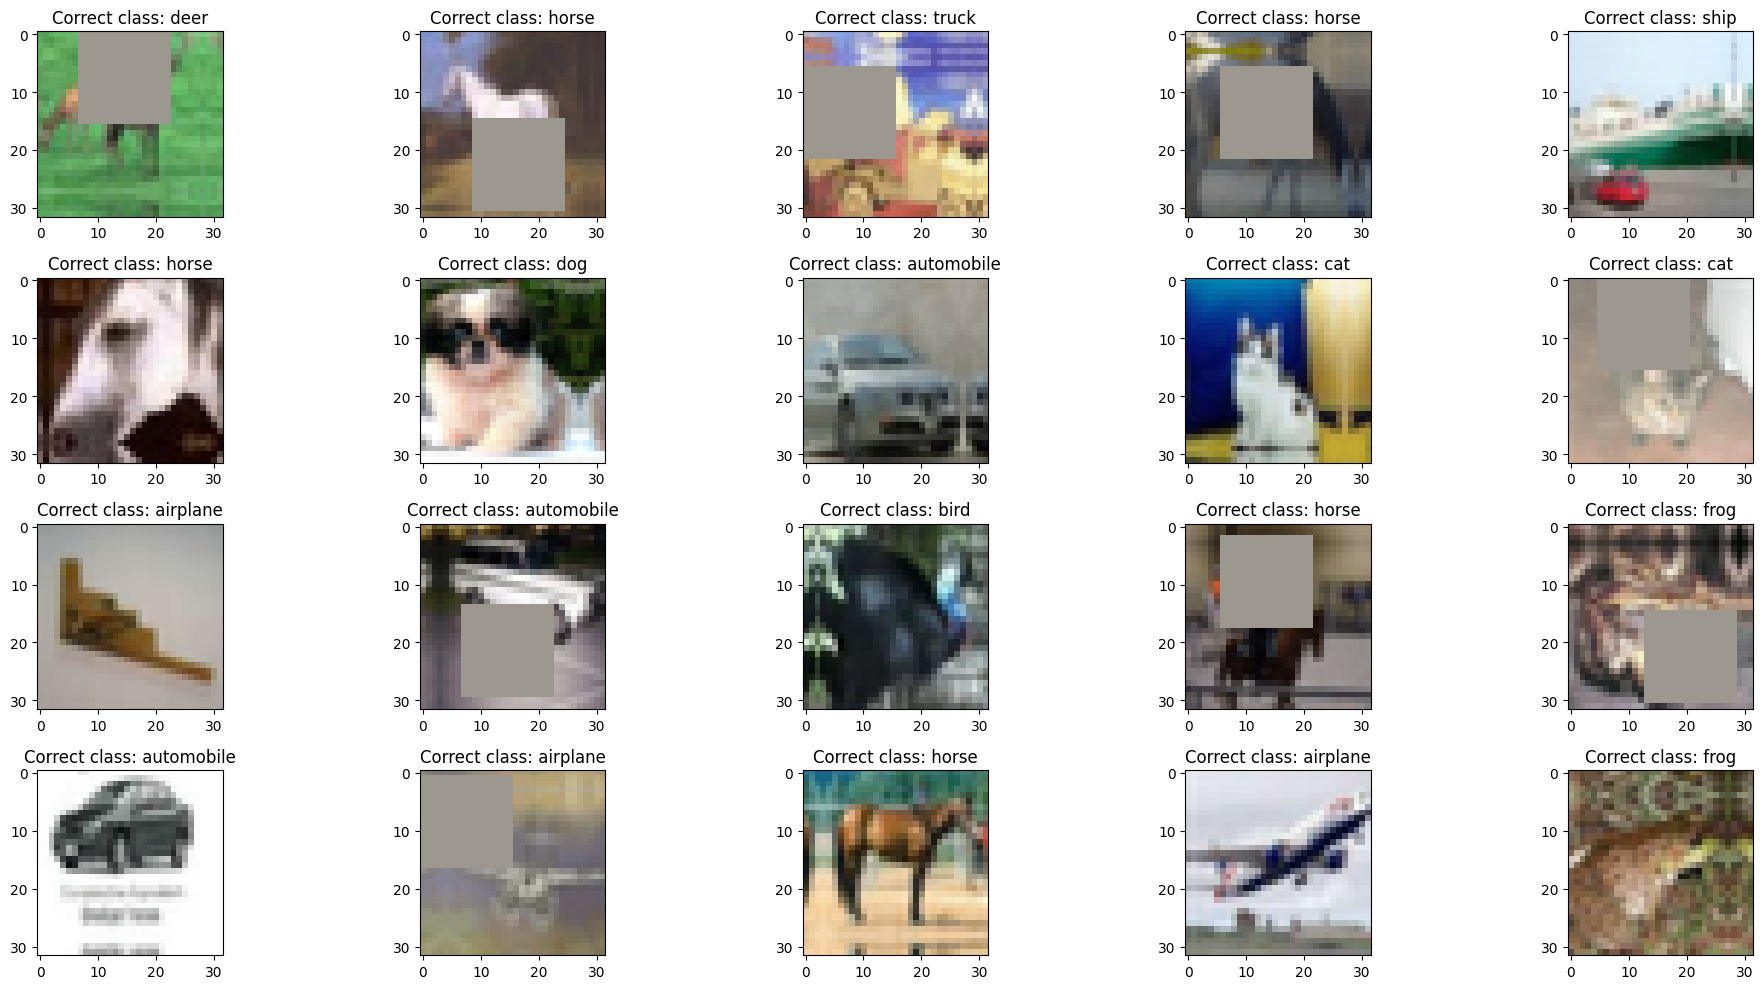

In [5]:
show_training_images(train_loader, 20, cifar10.classes)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.01E-03


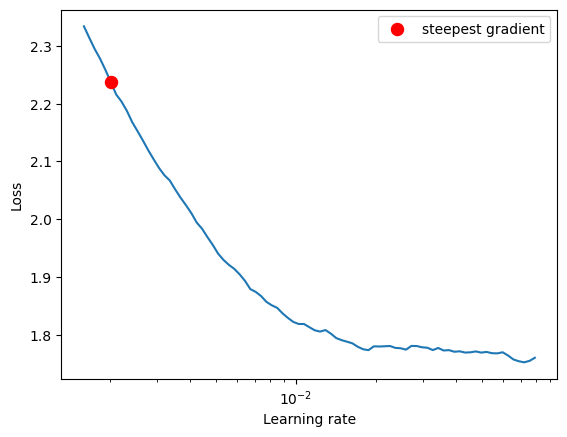

Min Loss = 1.753086244055849, Max LR = 0.07220809018385464


In [6]:
model = ResNet18()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()

# The model parameters are reset after this finishes
min_loss, max_lr = get_lr(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    end_lr=0.1,
    num_iter=100,
    step_mode="exp",
)

In [7]:
EPOCHS = 20

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=5 / EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(
    trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False
)

EPOCH = 1 | LR = 0.015048520389849952 | Loss = 1.53 | Batch = 97 | Accuracy = 35.60: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s] 


Test set: Average loss: 0.0045, Accuracy: 3459/10000 (34.59%)



EPOCH = 2 | LR = 0.029374959877861356 | Loss = 1.34 | Batch = 97 | Accuracy = 49.09: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0028, Accuracy: 5117/10000 (51.17%)



EPOCH = 3 | LR = 0.043701399365872765 | Loss = 1.12 | Batch = 97 | Accuracy = 56.74: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0026, Accuracy: 5795/10000 (57.95%)



EPOCH = 4 | LR = 0.05802783885388417 | Loss = 1.07 | Batch = 97 | Accuracy = 62.05: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s] 


Test set: Average loss: 0.0025, Accuracy: 5866/10000 (58.66%)



EPOCH = 5 | LR = 0.07215897394618469 | Loss = 0.92 | Batch = 97 | Accuracy = 65.54: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s] 


Test set: Average loss: 0.0026, Accuracy: 5823/10000 (58.23%)



EPOCH = 6 | LR = 0.06734558265452893 | Loss = 0.69 | Batch = 97 | Accuracy = 70.21: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]


Test set: Average loss: 0.0018, Accuracy: 7003/10000 (70.03%)



EPOCH = 7 | LR = 0.06253219136287319 | Loss = 0.81 | Batch = 97 | Accuracy = 74.18: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0017, Accuracy: 7160/10000 (71.60%)



EPOCH = 8 | LR = 0.057718800071217435 | Loss = 0.65 | Batch = 97 | Accuracy = 77.27: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]


Test set: Average loss: 0.0015, Accuracy: 7442/10000 (74.42%)



EPOCH = 9 | LR = 0.05290540877956168 | Loss = 0.57 | Batch = 97 | Accuracy = 79.43: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s] 


Test set: Average loss: 0.0011, Accuracy: 8172/10000 (81.72%)



EPOCH = 10 | LR = 0.04809201748790593 | Loss = 0.51 | Batch = 97 | Accuracy = 80.88: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s] 


Test set: Average loss: 0.0014, Accuracy: 7737/10000 (77.37%)



EPOCH = 11 | LR = 0.04327862619625018 | Loss = 0.48 | Batch = 97 | Accuracy = 82.91: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s] 


Test set: Average loss: 0.0015, Accuracy: 7625/10000 (76.25%)



EPOCH = 12 | LR = 0.03846523490459443 | Loss = 0.46 | Batch = 97 | Accuracy = 84.01: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s] 


Test set: Average loss: 0.0008, Accuracy: 8671/10000 (86.71%)



EPOCH = 13 | LR = 0.03365184361293868 | Loss = 0.44 | Batch = 97 | Accuracy = 85.29: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s] 


Test set: Average loss: 0.0008, Accuracy: 8742/10000 (87.42%)



EPOCH = 14 | LR = 0.02883845232128293 | Loss = 0.46 | Batch = 97 | Accuracy = 86.35: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s] 


Test set: Average loss: 0.0007, Accuracy: 8744/10000 (87.44%)



EPOCH = 15 | LR = 0.024025061029627176 | Loss = 0.38 | Batch = 97 | Accuracy = 87.66: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0008, Accuracy: 8750/10000 (87.50%)



EPOCH = 16 | LR = 0.019211669737971428 | Loss = 0.30 | Batch = 97 | Accuracy = 88.90: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0007, Accuracy: 8883/10000 (88.83%)



EPOCH = 17 | LR = 0.01439827844631568 | Loss = 0.30 | Batch = 97 | Accuracy = 90.30: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s] 


Test set: Average loss: 0.0006, Accuracy: 9003/10000 (90.03%)



EPOCH = 18 | LR = 0.009584887154659924 | Loss = 0.26 | Batch = 97 | Accuracy = 91.40: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0006, Accuracy: 9048/10000 (90.48%)



EPOCH = 19 | LR = 0.004771495863004183 | Loss = 0.20 | Batch = 97 | Accuracy = 92.47: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s] 


Test set: Average loss: 0.0006, Accuracy: 9078/10000 (90.78%)



EPOCH = 20 | LR = -4.18954286515727e-05 | Loss = 0.23 | Batch = 97 | Accuracy = 93.32: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s] 


Test set: Average loss: 0.0006, Accuracy: 9138/10000 (91.38%)



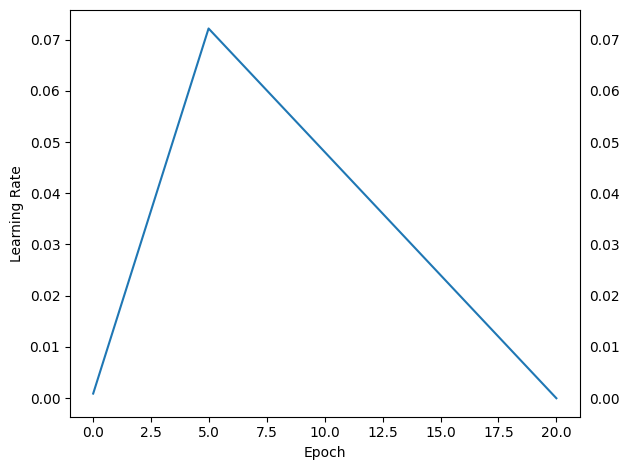

In [8]:
show_lr_history(trainer, EPOCHS)

In [9]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.07220809018385464
Min LR = -4.18954286515727e-05


# Get misclassified images from Tester


In [10]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Show misclassified images


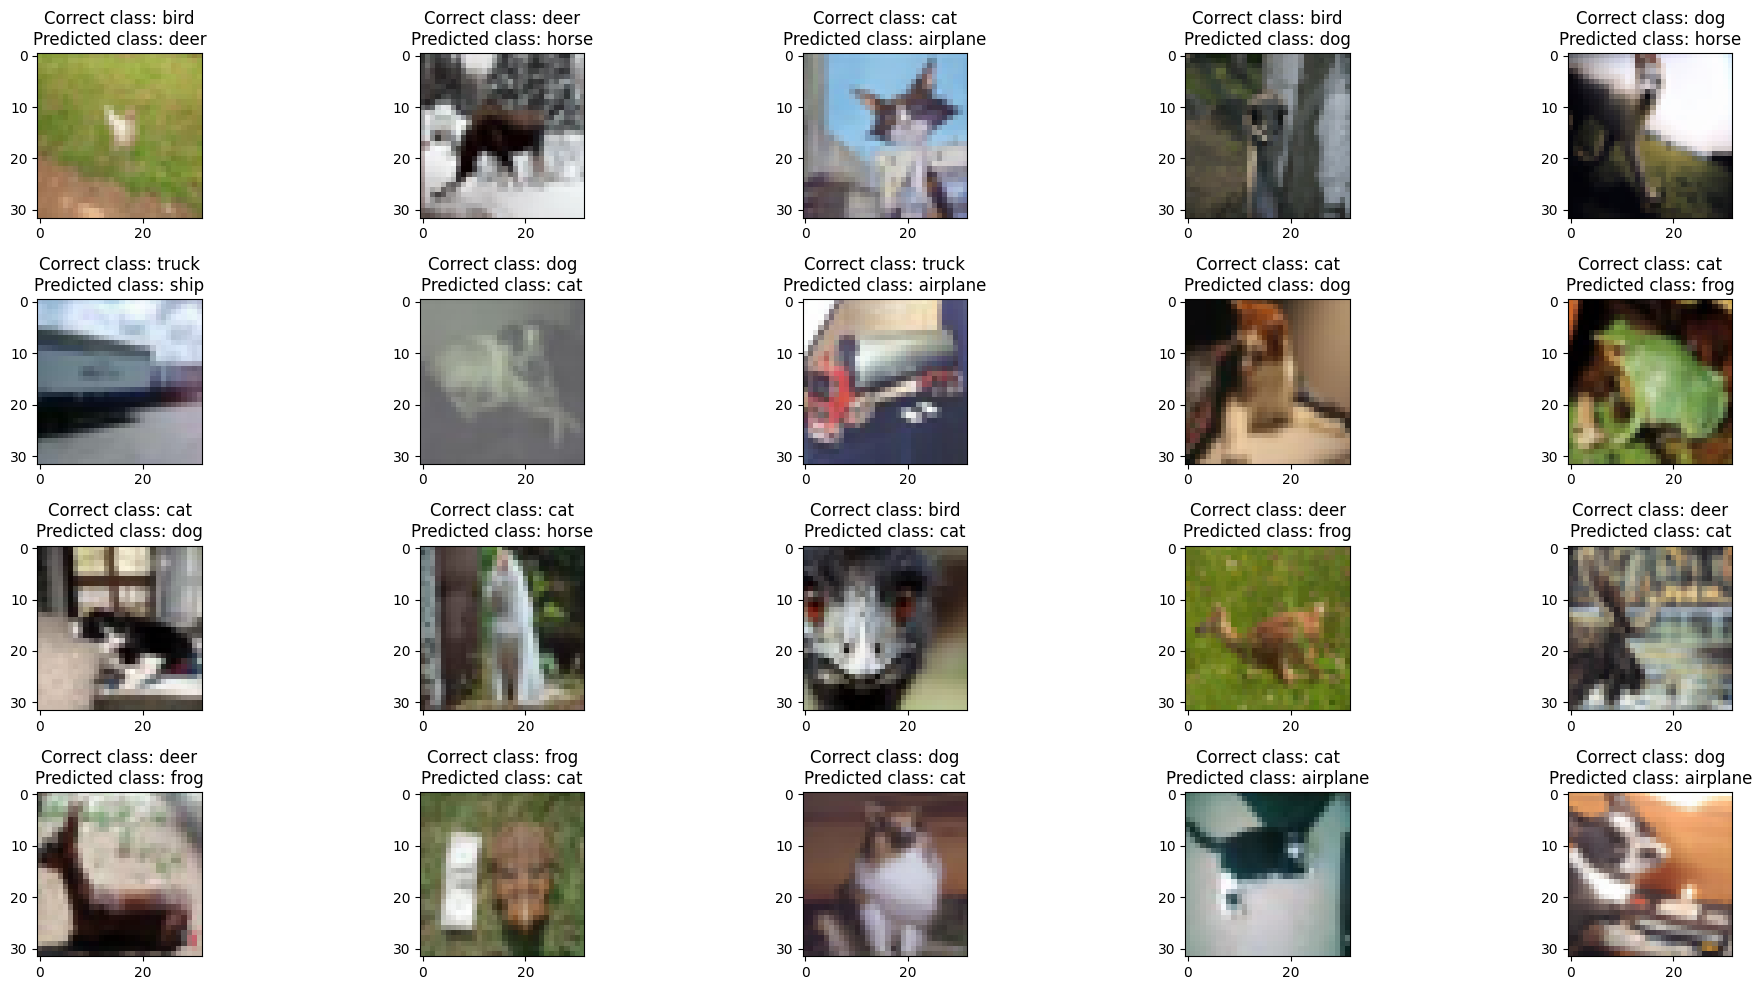

In [11]:
show_misclassified_images(
    misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes
)

# Grad-CAM of misclassified images for correct labels

_This is what model sees for correct labels but it was not enough for correct prediction._


- ## Layer 2


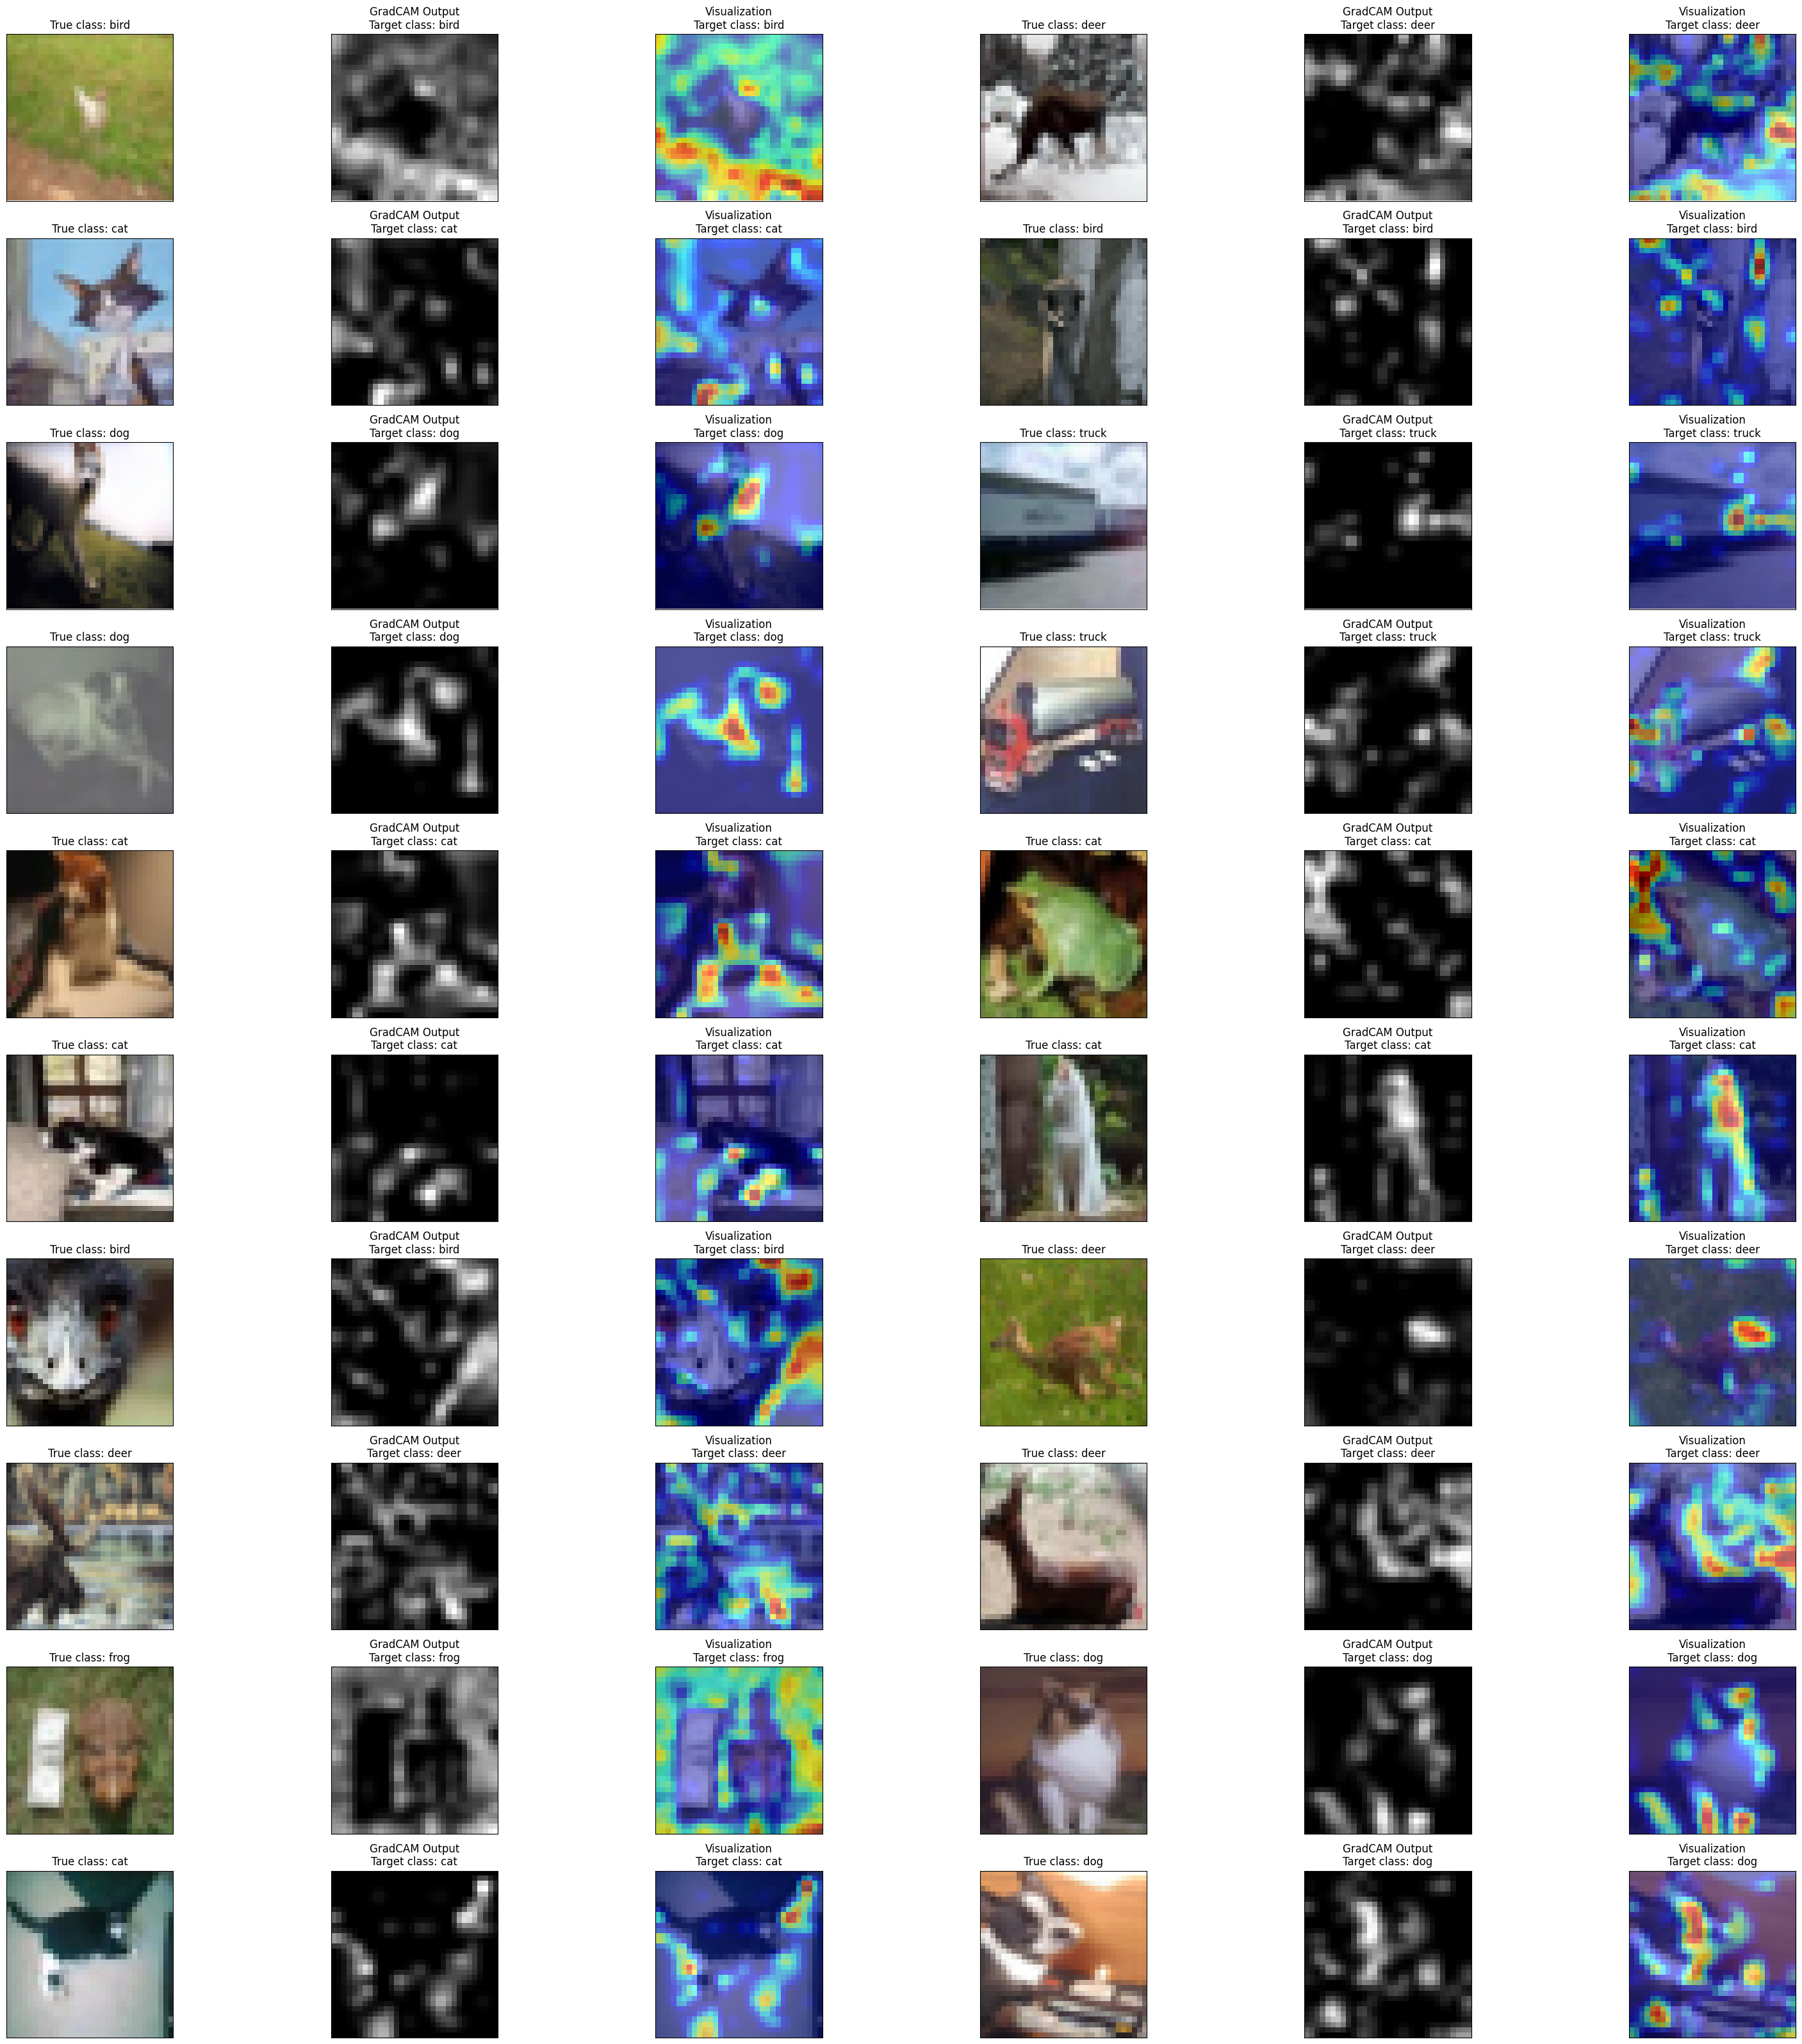

In [12]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    labels[:20],
    "layer2",
    cifar10.classes,
)

- ## Layer 3


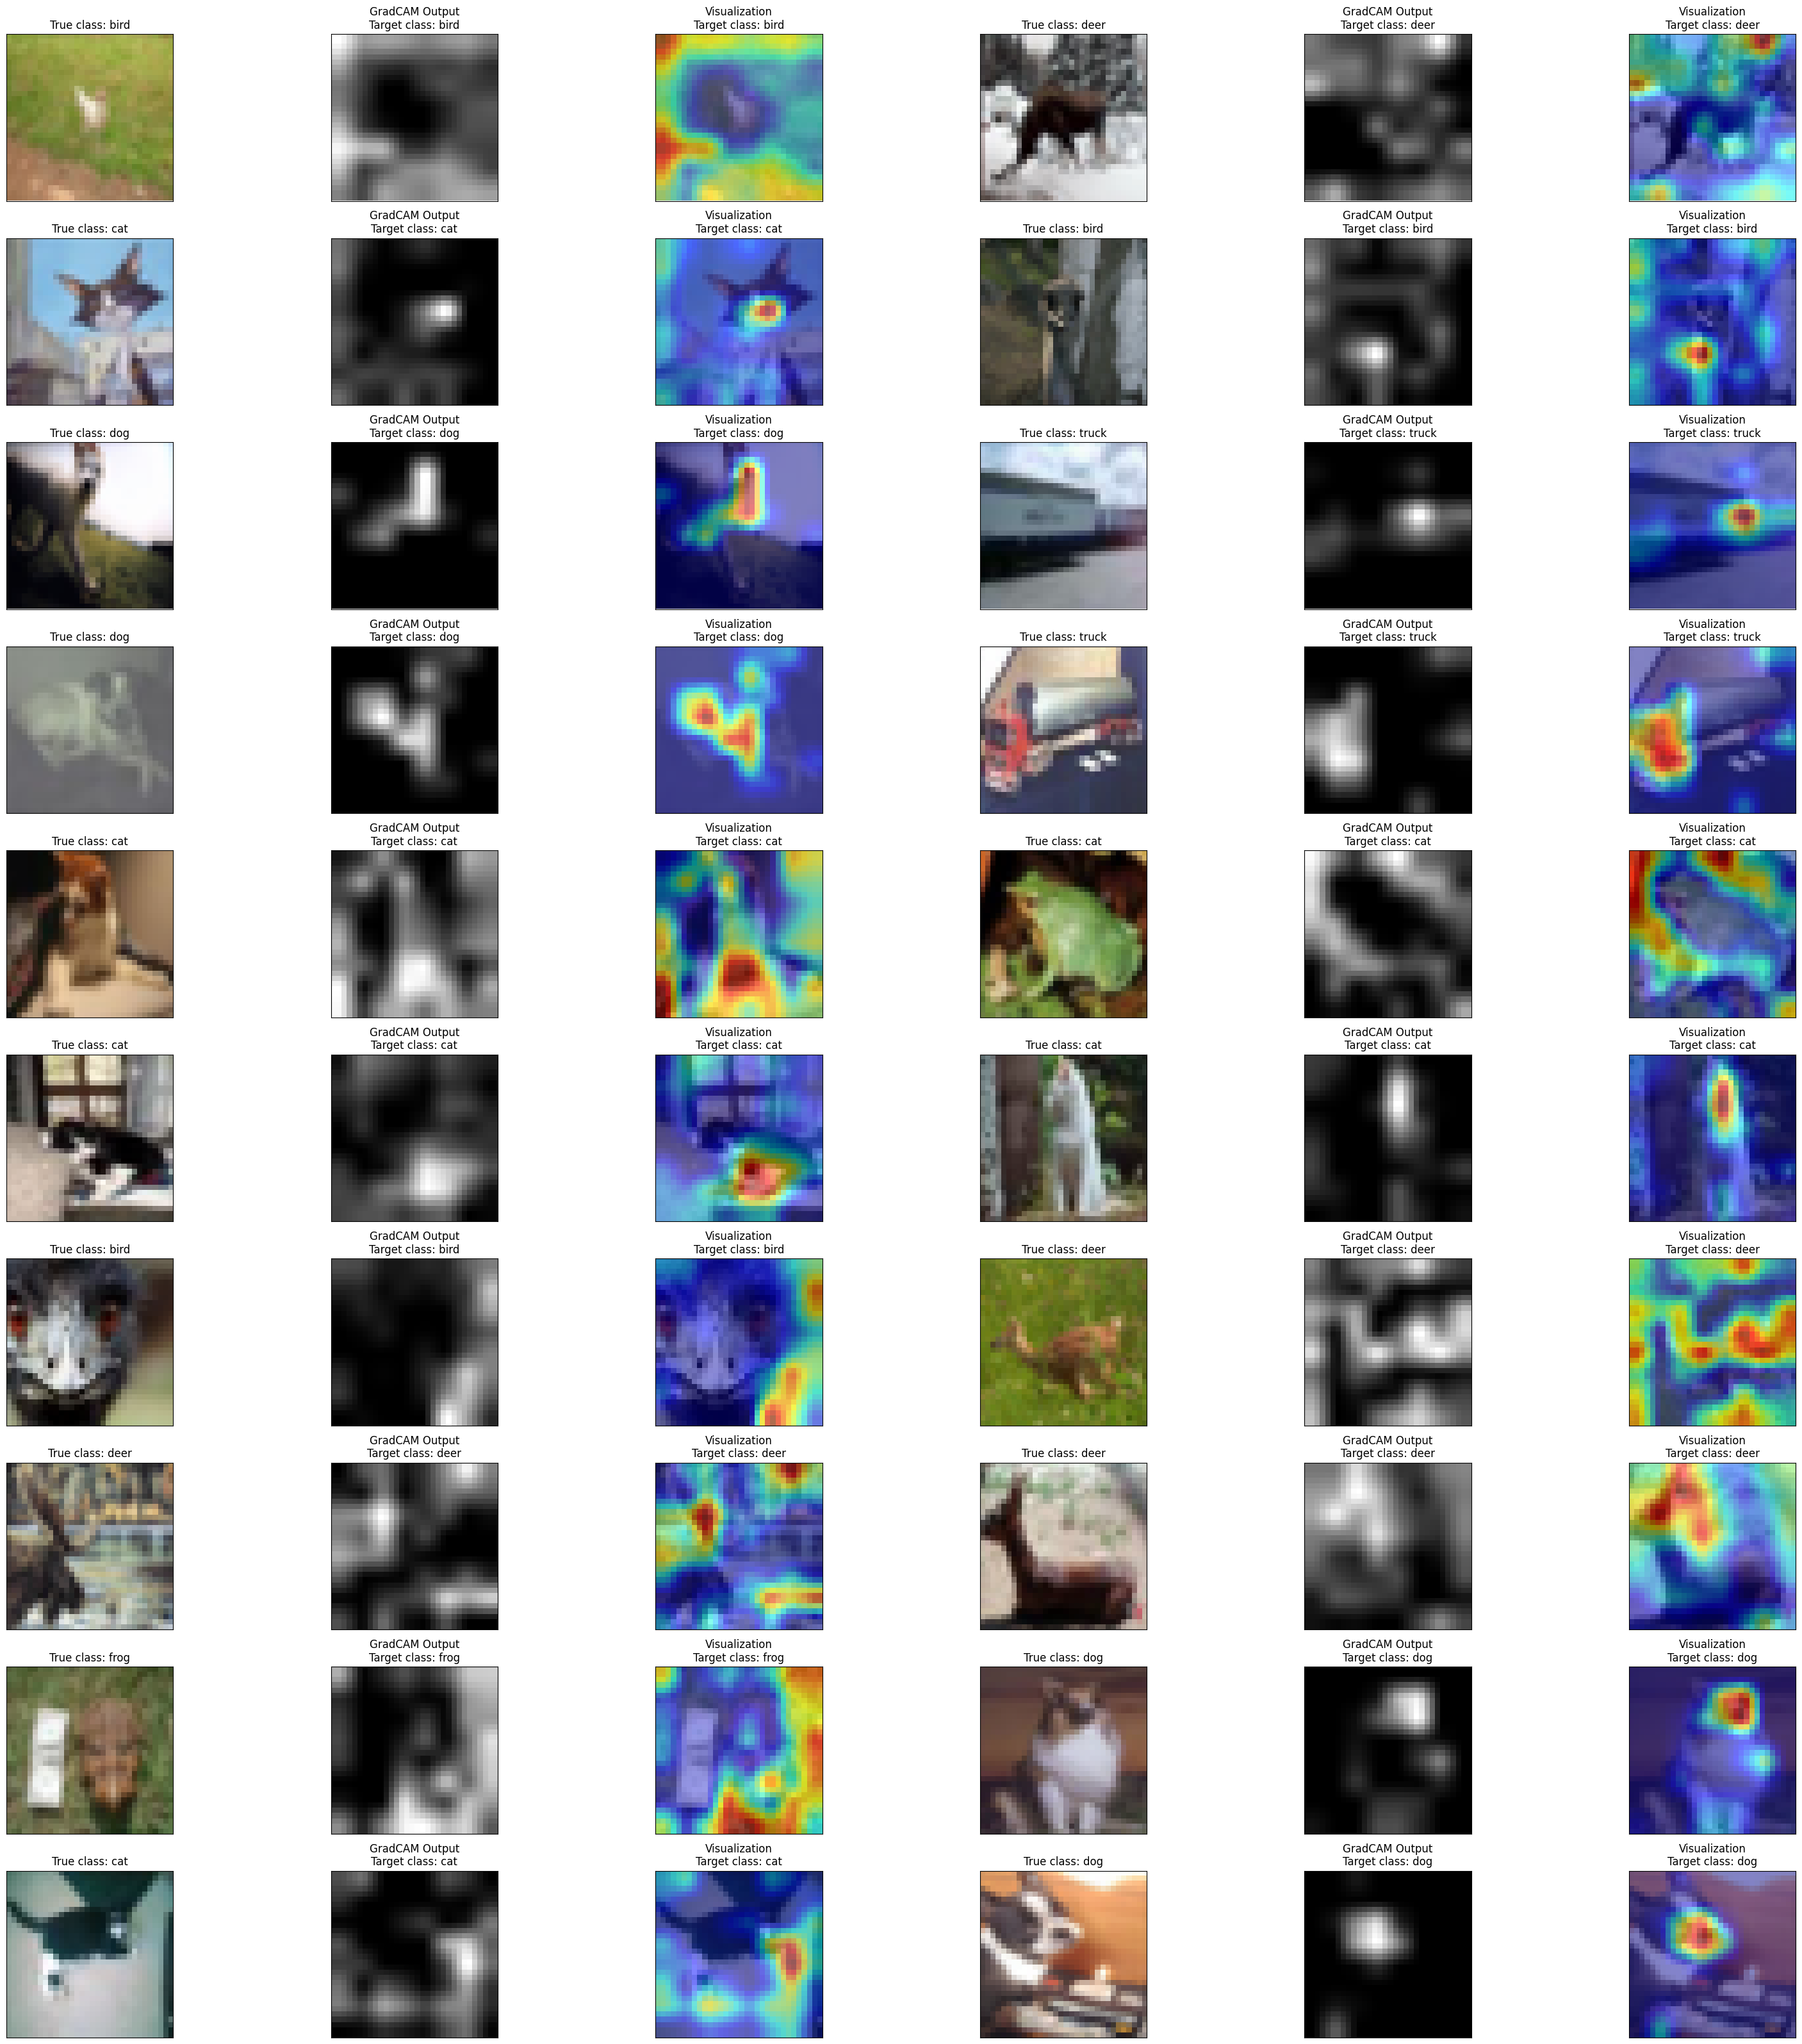

In [13]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    labels[:20],
    "layer3",
    cifar10.classes,
)

# Grad-CAM of misclassified images for predictions

_This is what model sees that it based its prediction on._


- ## Layer 2


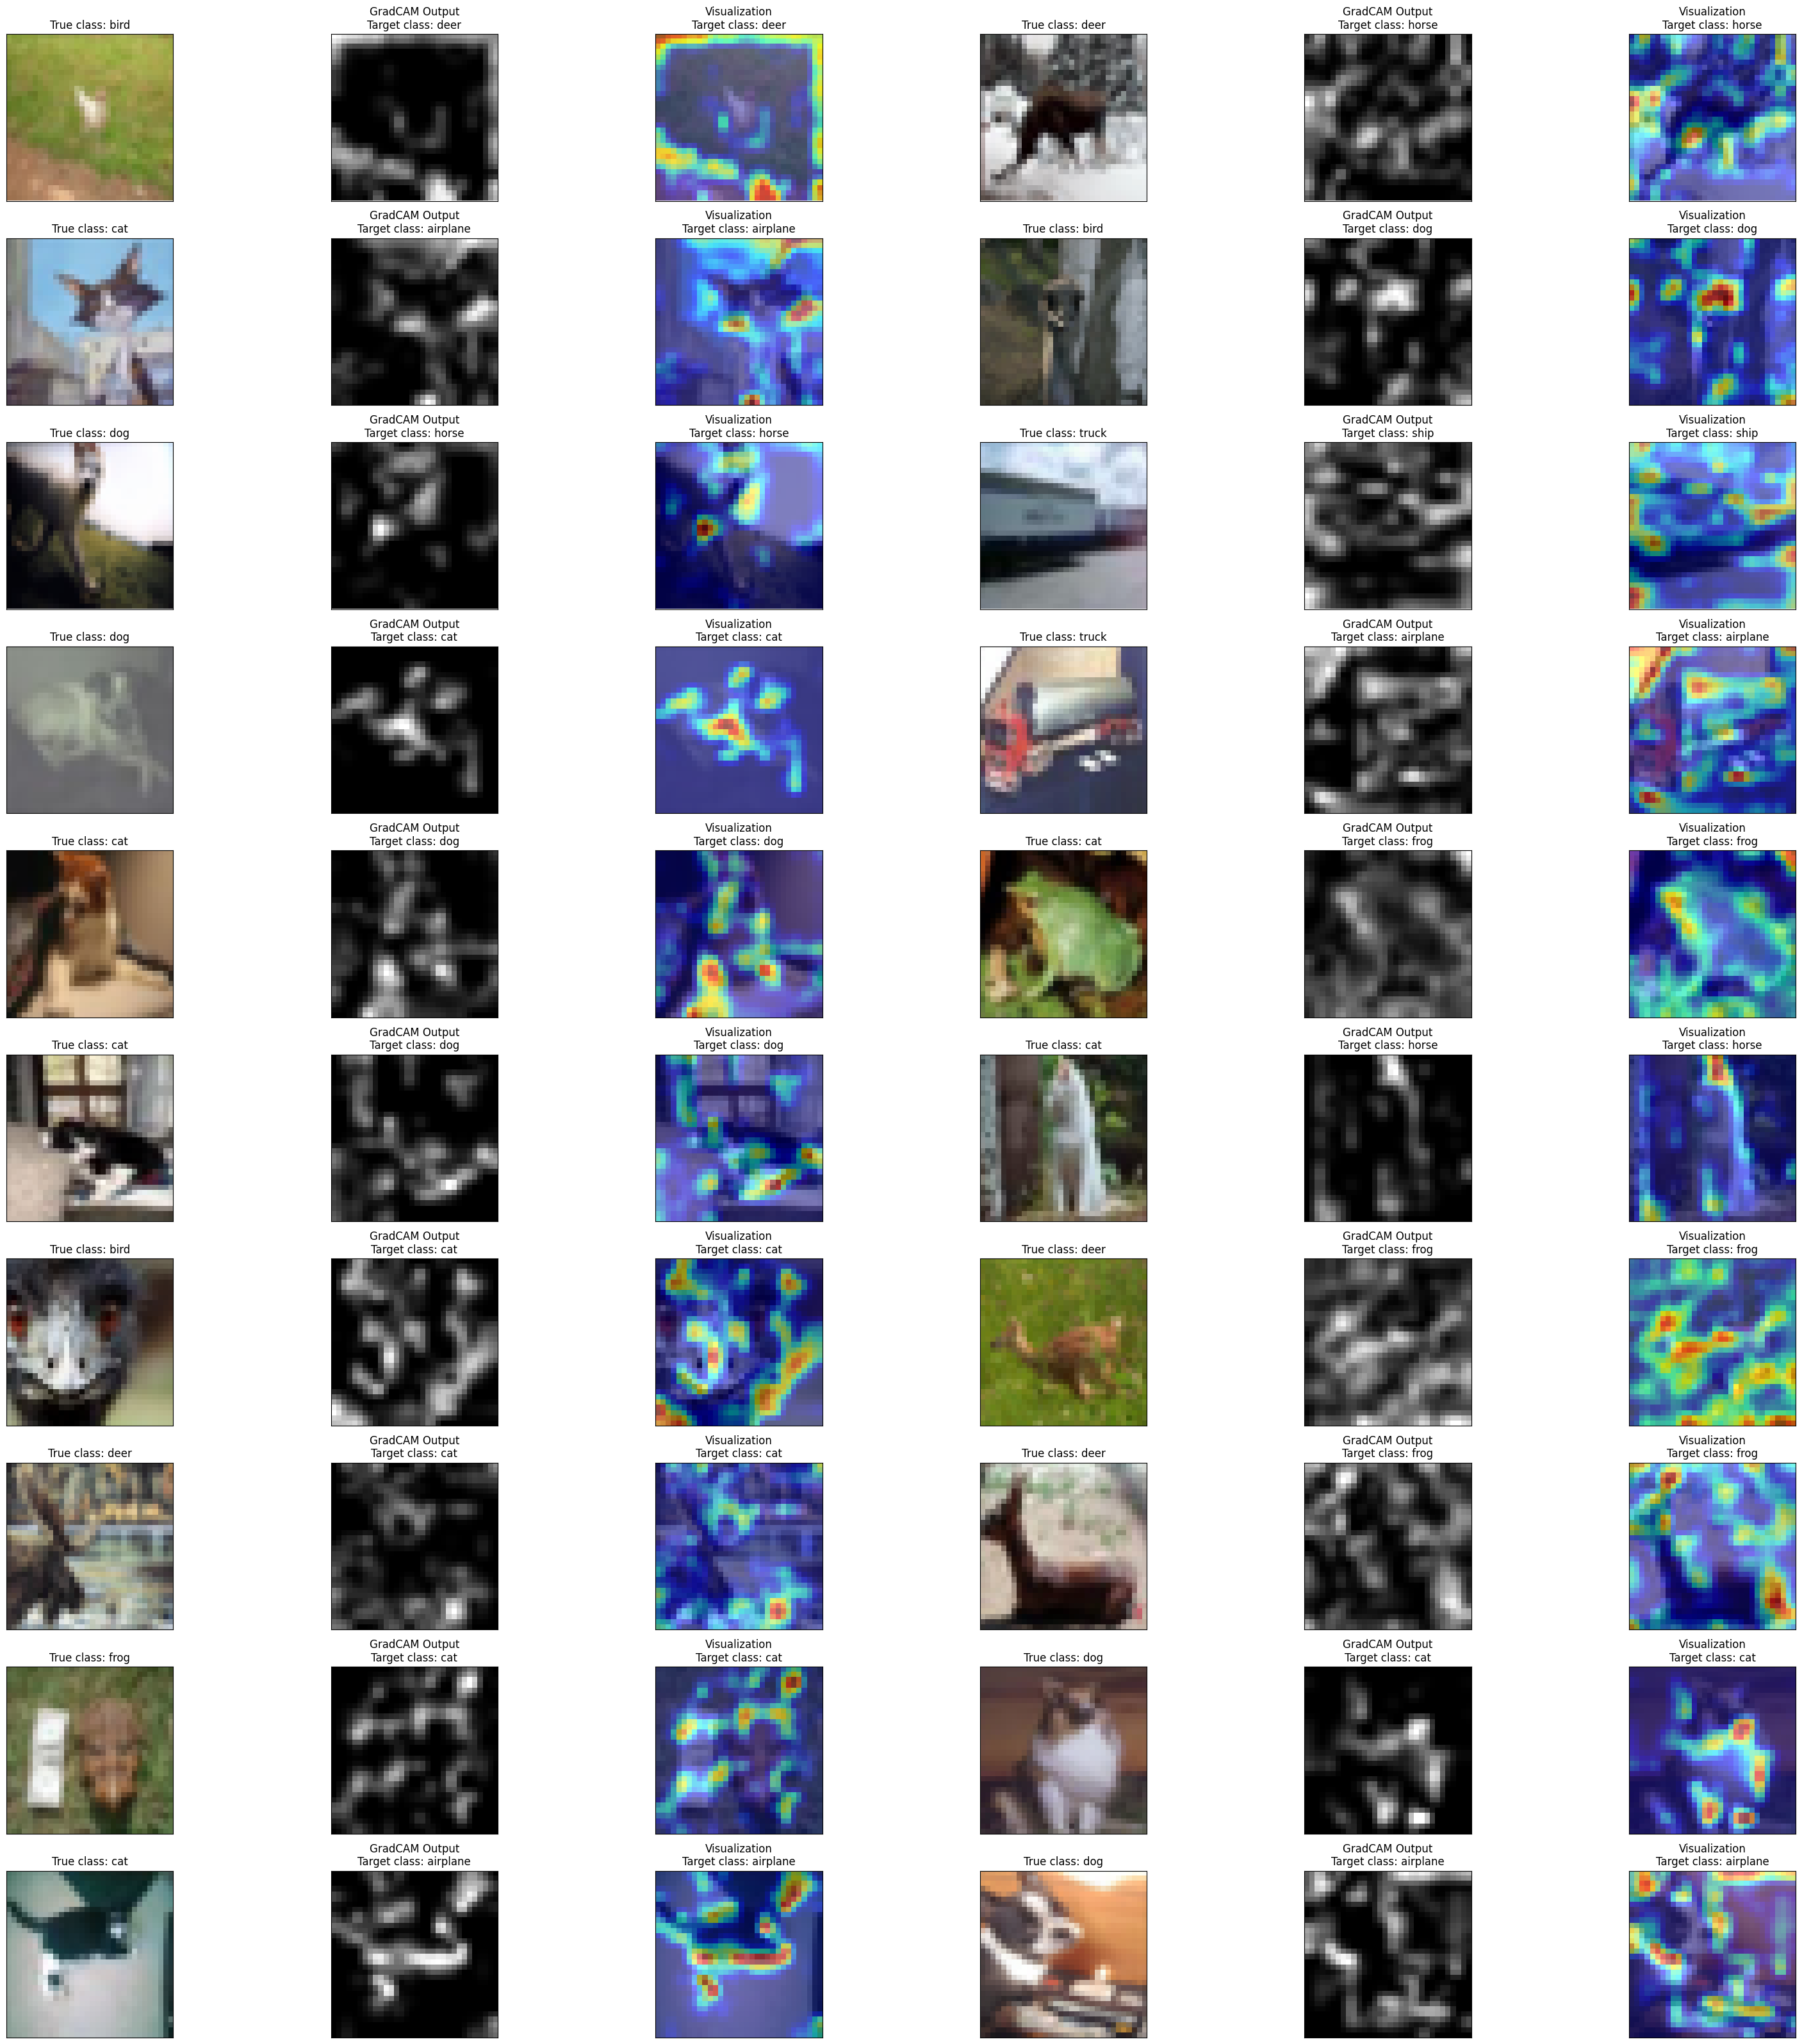

In [14]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    predictions[:20],
    "layer2",
    cifar10.classes,
)

- ## Layer 3


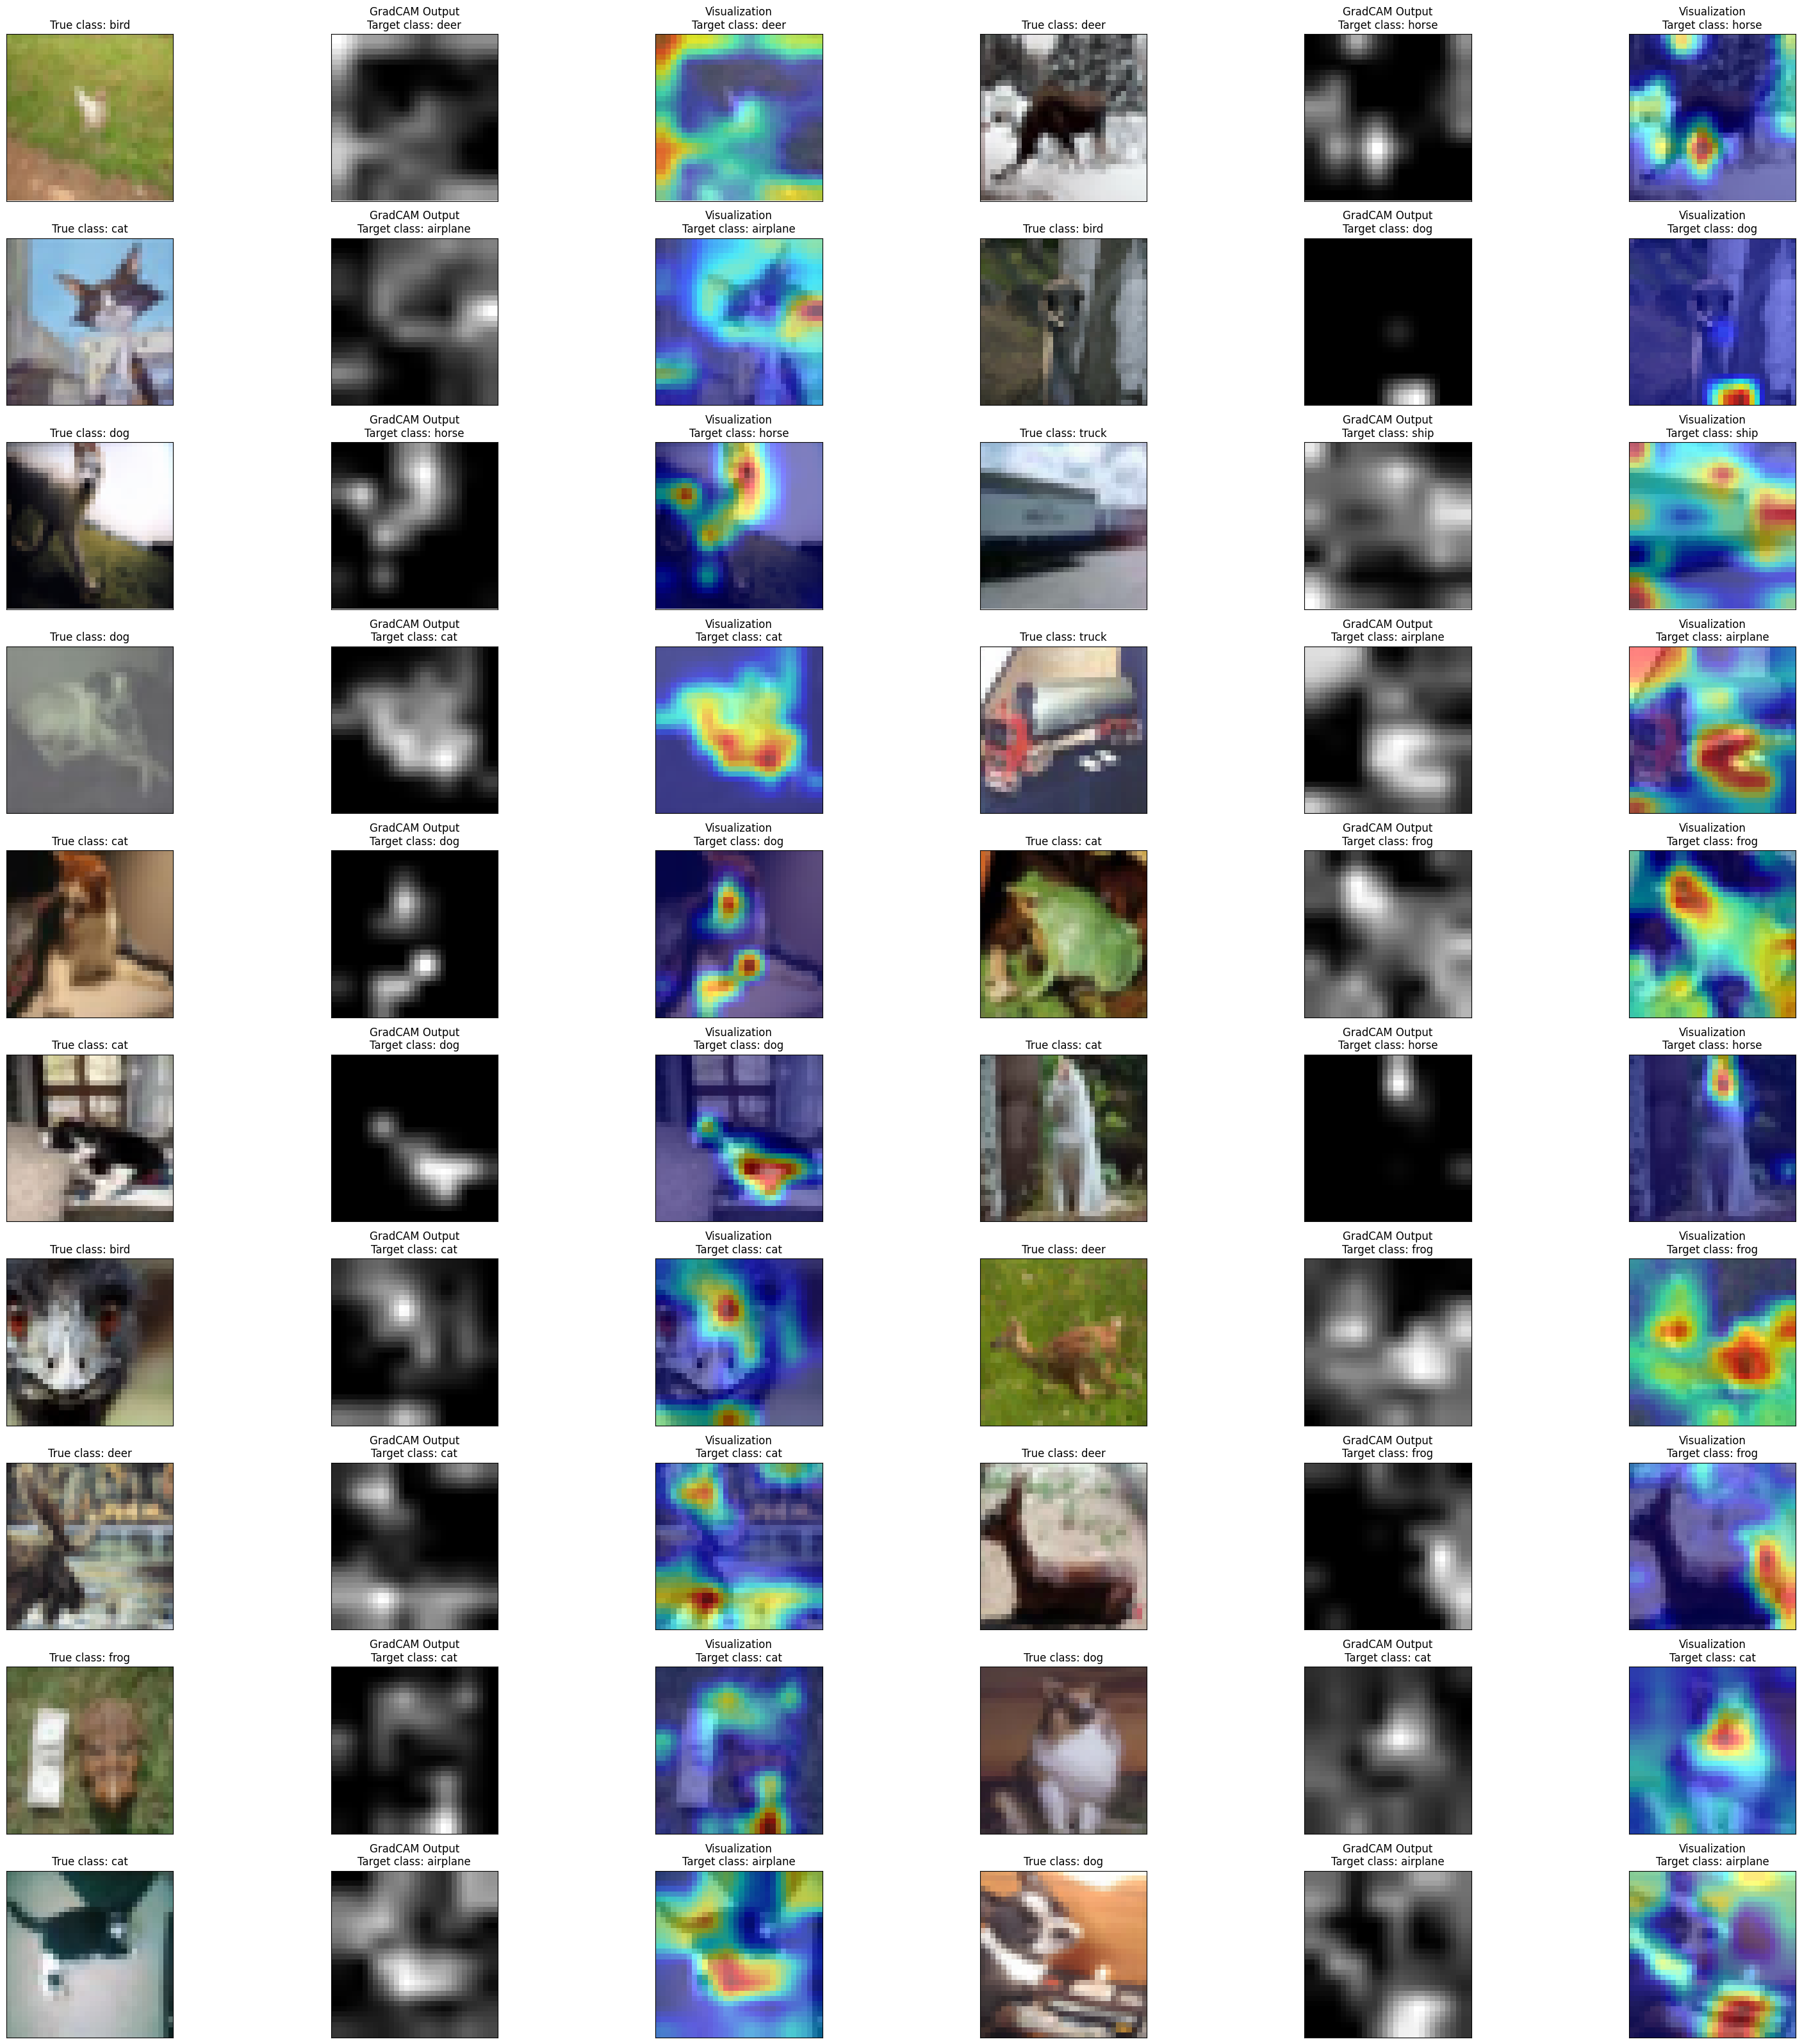

In [15]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    predictions[:20],
    "layer3",
    cifar10.classes,
)

# Loss and Accuracy Graphs for Training and Testing


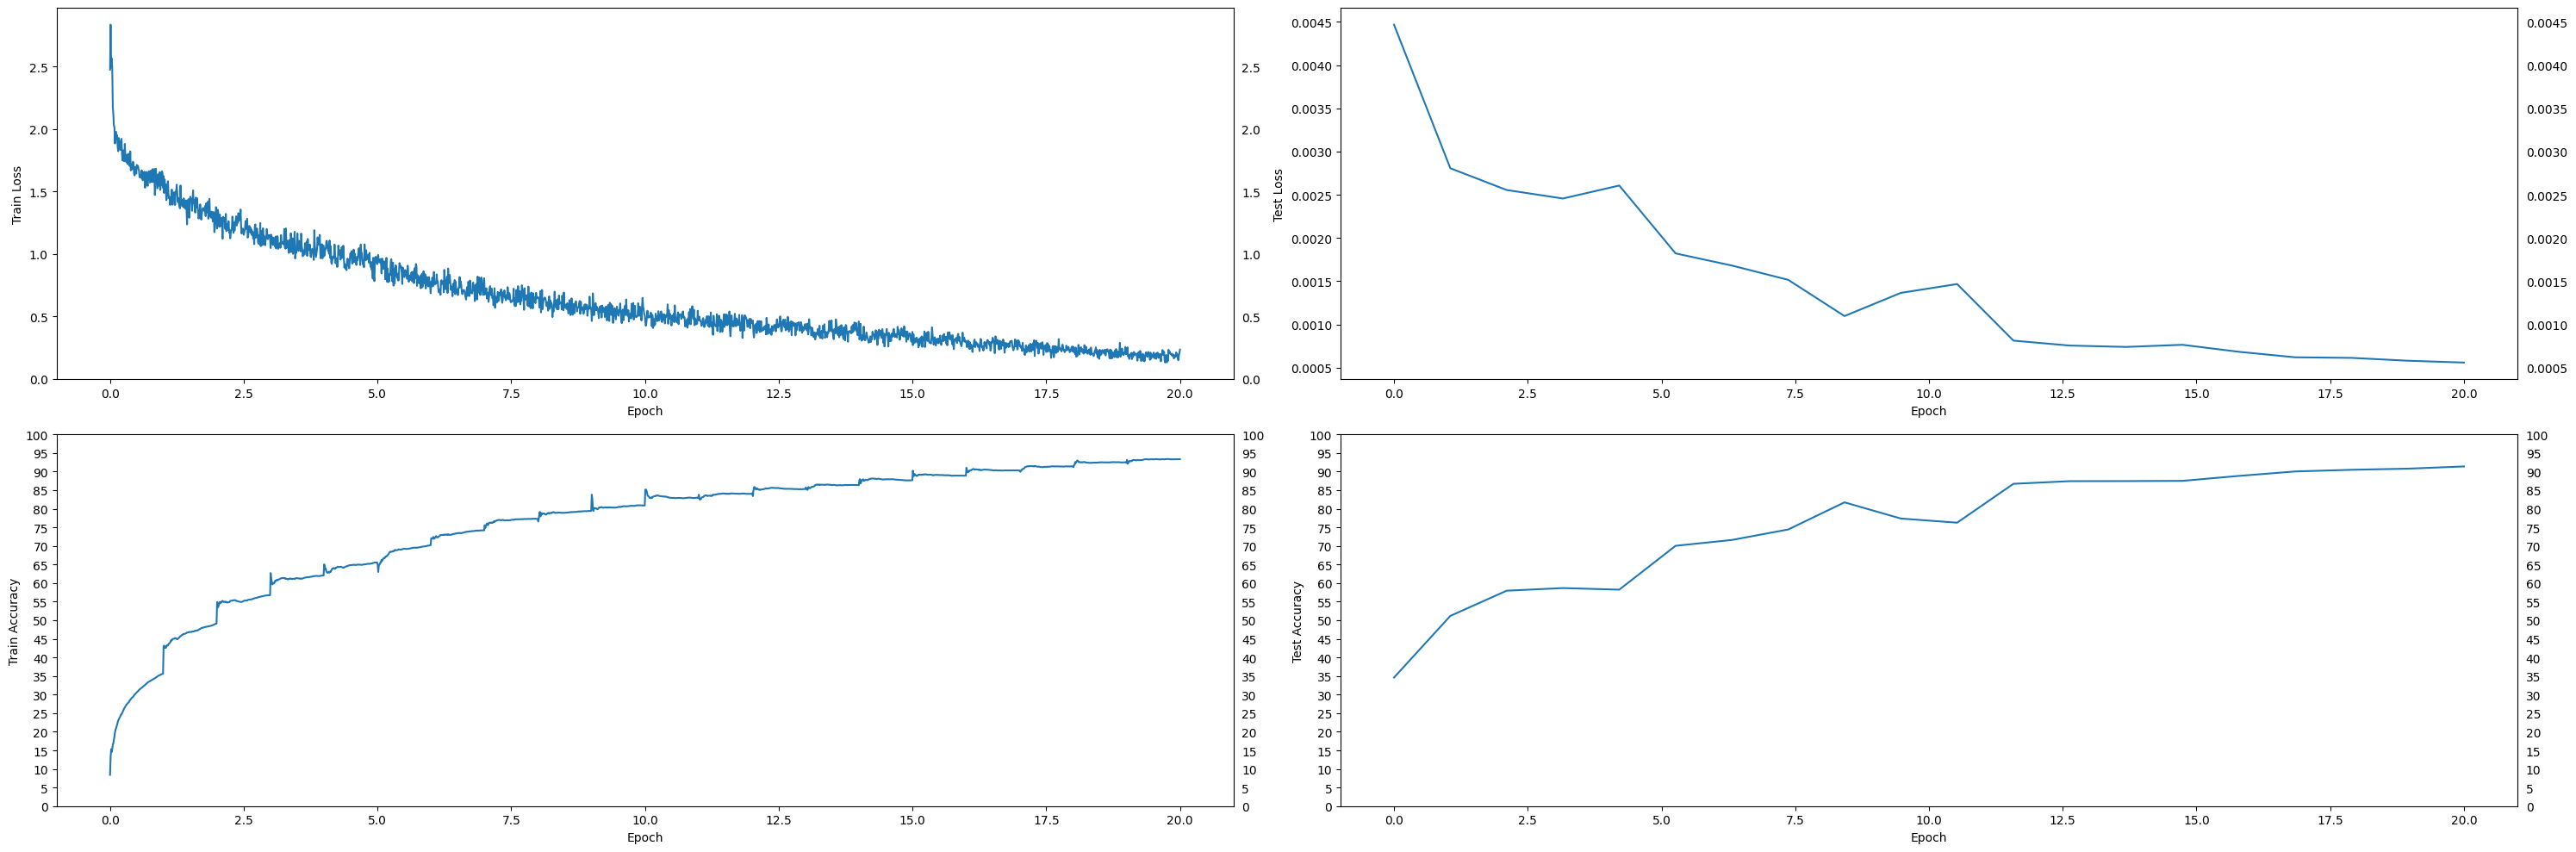

In [16]:
show_losses_and_accuracies(trainer, tester, EPOCHS)